## Imports

In [1]:
"""------------SECTION IMPORTS---------------------"""
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
'''------------SECTION USER VARIABLES--------------'''
# Define the path to your datafolder below
your_datapath = '../data/'

# Define search space for number of trees in random forest and depth of trees
num_trees_min = 64
num_trees_max = 128

depth_min = 2
depth_max = 7

# Useful functions

In [2]:
# Function that returns every possible subset (except the empty set) of the input list l
def subsets(l: object) -> object:
    subset_list = []
    for i in range(len(l) + 1):
        for j in range(i):
            subset_list.append(l[j: i])
    return subset_list

# Import data
NaN data needs to be dropped for RF to work
1. I drop the columns which have NaN values which is all the new data
2. I create a new dataframe which has no columns containing NaN values
3. Copy the `next_prevalence` column to this dataframe and once again drop rows containing NaN

In [3]:
df = pd.read_csv("data/no_missings_mon.csv")

In [4]:
df.head()

,Unnamed: 0,date,district,prevalence,next_prevalence,prevalence_6lag,ndvi,ipc,population,month,district_encoded,increase
0,445,2018-01-01,Qansax Dheere,0.2886,0.2886,0.3588,0.15,0.09,123818.085,1,63,True
1,446,2018-01-01,Jilib,0.3926,0.3926,0.4316,0.22,0.09,103739.085,1,51,True
2,447,2018-01-01,Wanla Weyn,0.3510,0.3510,0.3692,0.14,0.00,227667.915,1,74,True
3,448,2018-01-01,Qoryooley,0.3510,0.3510,0.3692,0.20,0.09,196309.485,1,65,True
4,449,2018-01-01,Xudur,0.4862,0.4862,0.4862,0.11,0.14,113853.105,1,77,True


# Define X and y

In [5]:
'''------------SECTION RANDOM FOREST CROSS VALIDATION--------------'''
# WARNING: this process can take some time, since there are a lot of hyperparameters to investigate. The search space can be manually reduced to speed up the process.

# Create empty list to store model scores
parameter_scores = []

# Define target and explanatory variables
X = df.select_dtypes(exclude=["category","object"]).drop(["increase", "prevalence", "next_prevalence"],axis=1)
y = df['next_prevalence'].values

In [6]:
X.head()

,Unnamed: 0,prevalence_6lag,ndvi,ipc,population,month,district_encoded
0,445,0.3588,0.15,0.09,123818.085,1,63
1,446,0.4316,0.22,0.09,103739.085,1,51
2,447,0.3692,0.14,0.00,227667.915,1,74
3,448,0.3692,0.20,0.09,196309.485,1,65
4,449,0.4862,0.11,0.14,113853.105,1,77


In [7]:
y

array([0.2886    , 0.3926    , 0.351     , ..., 0.23918765, 0.26840601,
       0.35155563])

# Train split

In [8]:
train_split = int(0.8*len(X))

## RF-CV

In [9]:
for num_trees in tqdm(range(num_trees_min, num_trees_max)):

    for depth in range(depth_min, depth_max):

        # Investigate every subset of explanatory variables
        # noinspection PyTypeChecker
        for features in subsets(X.columns):
            # First CV split. The 207 refers to the first 3 observations for the 69 districts in the data.
            #
            Xtrain = X[:207][features].copy().values
            ytrain = y[:207]
            Xtest = X[207:][features].copy().values
            ytest = y[207:]

            # Create a RandomForestRegressor with the selected hyperparameters and random state 0.
            clf = RandomForestRegressor(n_estimators=num_trees, max_depth=depth, random_state=0, n_jobs=-1)

            # Fit to the training data
            clf.fit(Xtrain, ytrain)

            # Make a prediction on the test data
            predictions = clf.predict(Xtest)

            # Calculate mean absolute error
            MAE1 = mean_absolute_error(ytest, predictions)

            # Second CV split. The 276 refers to the first 4 observations for the 69 districts in the data.
            Xtrain = X[:276][features].copy().values
            ytrain = y[:276]
            Xtest = X[276:][features].copy().values
            ytest = y[276:]

            # Create a RandomForestRegressor with the selected hyperparameters and random state 0.
            clf = RandomForestRegressor(n_estimators=num_trees, max_depth=depth, random_state=0, n_jobs=-1)

            # Fit to the training data
            clf.fit(Xtrain, ytrain)

            # Make a prediction on the test data
            predictions = clf.predict(Xtest)

            # Calculate mean absolute error
            MAE2 = mean_absolute_error(ytest, predictions)

            # Calculate the mean MAE over the two folds
            mean_MAE = (MAE1 + MAE2) / 2

            # Store the mean MAE together with the used hyperparameters in list
            parameter_scores.append((mean_MAE, num_trees, depth, features))

# Sort the models based on score and retrieve the hyperparameters of the best model
parameter_scores.sort(key=lambda x: x[0])
best_model_score = parameter_scores[0][0]
best_model_trees = parameter_scores[0][1]
best_model_depth = parameter_scores[0][2]
best_model_columns = list(parameter_scores[0][3])

'''------------SECTION FINAL EVALUATION--------------'''
X = df[best_model_columns].values
y = df['next_prevalence'].values

# If there is only one explanatory variable, the values need to be reshaped for the model
if len(best_model_columns) == 1:
    X = X.reshape(-1, 1)

# Perform evaluation on full data
Xtrain = X[:345]
ytrain = y[:345]
Xtest = X[345:]
ytest = y[345:]

clf = RandomForestRegressor(n_estimators=best_model_trees, max_depth=best_model_depth, random_state=0, n_jobs=-1)
clf.fit(Xtrain, ytrain)
predictions = clf.predict(Xtest)

len(predictions)

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [39:45<00:00, 37.27s/it]


2553

## `prevalence` on line 2 in the next block is not found within the dataset. Needs to be fixed

In [12]:
# Calculate MAE
MAE = mean_absolute_error(ytest, predictions)

# Generate boolean values for increase or decrease in prevalence. 0 if next prevalence is smaller than current prevalence, 1 otherwise.
increase = [0 if x < y else 1 for x in df.iloc[345:]['next_prevalence'] for y in df.iloc[345:]['prevalence']]
predicted_increase = [0 if x < y else 1 for x in predictions for y in df.iloc[345:]['prevalence']]

# Calculate accuracy of predicted boolean increase/decrease
acc = accuracy_score(increase, predicted_increase)

# Print model parameters
print('no. of trees: ' + str(best_model_trees) + '\nmax_depth: ' + str(best_model_depth) + '\ncolumns: ' + str(
    best_model_columns))

# Print model scores
print(MAE, acc)

no. of trees: 118
max_depth: 6
columns: ['district_encoded']
0.07563633035885876 0.769578856944105


# Save model

In [13]:
filename = 'baseline_monthly_model.joblib'
joblib.dump(clf, filename)

['baseline_monthly_model.joblib']

# Metrics

In [17]:
from helper_metrics import make_confusion_matrix, roc_curve_gen, calculate_results

In [18]:
from helper_metrics import make_confusion_matrix

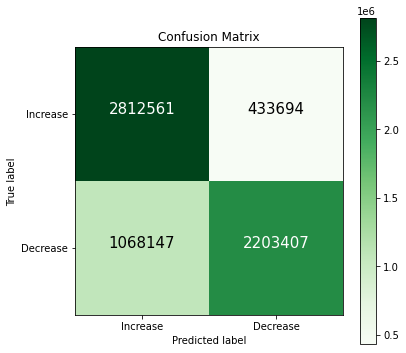

In [19]:
make_confusion_matrix(increase, predicted_increase,figsize=(6,6),classes=["Increase", "Decrease"],cmap=plt.cm.Greens)

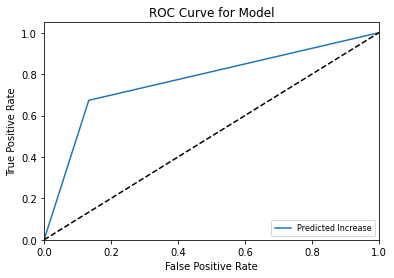

In [20]:
roc_curve_gen(increase, predicted_increase)

In [21]:
calculate_results(increase, predicted_increase, average="weighted")

{'accuracy': 76.95788569441049,
 'precision': 0.780363002140754,
 'recall': 0.769578856944105,
 'f1': 0.7674641229554572}